In [1]:
# imports
import sys
import pandas as pd
sys.path.append('../../') # to access the files in higher directories
sys.path.append('../') # to access the files in higher directories
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import core_exp as cx
import core_calib as cal
import core_tools as ct

In [2]:
params = {
    # exp
    "seed": 0,
    "runs": 1,
    "path": "../../",
    "exp_name": ct.generate_readable_short_id("Depth_Diff_Cov"),
    "split": "CV", #CV, random_split
    "cv_folds": 10,
    "plot": True,

    # "calib_methods": ["RF", 
    #                   "Platt", "ISO", "Beta", "CRF", "VA",
    #                   "SVM_d", "LR_d",
    #                  ],

    "calib_methods": ["RF_d", "RF_opt", "RF_large",
                      "Platt", "ISO", "Beta", "CRF", "VA",
                      "Rank"#, "Elkan", "tlr",                      
                      ],

    "metrics": ["acc", "tce", "logloss", "brier", "ece", "auc"],
    
    #data
    "data_name": "synthetic",
    "plot_data": True,
    "data_size": 1000,
    "n_features": 2,

    "class1_mean_min":0, 
    "class1_mean_max":1, 
    "class2_mean_min":1, 
    "class2_mean_max":3, 

    "class1_cov_min":4, 
    "class1_cov_max":5,
    "class2_cov_min":1, 
    "class2_cov_max":2, 


    # calib param
    "bin_strategy": "uniform",
    "ece_bins": 20,
    "boot_size": 5000,
    "boot_count": 40,

    "opt_cv":5, 
    "opt_n_iter":40,
    "opt_top_K": 5,
    "search_space": {
                    "n_estimators": [10],
                    "max_depth": [2,3,4,5,6,7,8,10,15,20,30,40,50,60,100],
                    "criterion": ["gini", "entropy"],
                    "max_features": ["sqrt", "log2"],
                    "min_samples_split": [2,3,4,5],
                    "min_samples_leaf": [1,2,3],
                    },
    # RF hyper opt
    "oob": False,
    "laplace": 0, # if set to 1, OOB must be false

    "exp_key": "max_depth",
    "exp_values":  [1,2,3,4,5,6,7,8,9,10,20] 
}

ct.save_params(params)

In [3]:
calib_results_dict, data_list = cx.run_exp(params["exp_key"], params["exp_values"], params)

Success in 2 n_features accuracy 0.745 runs 49
exp_param 1 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 2 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 3 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 4 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 5 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 6 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 7 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 8 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 9 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 10 done
Success in 2 n_features accuracy 0.745 runs 49
exp_param 20 done


In [4]:
tables = cal.mean_and_ranking_table(calib_results_dict, 
                                    params["metrics"], 
                                    params["calib_methods"], 
                                    data_list, 
                                    mean_and_rank=True, 
                                    std=True)

In [5]:
for metric in params["metrics"]:
    print(metric, " ", params["calib_methods"][tables[metric].loc["Rank"].argmin()])
    tables[metric].to_csv(f"./results/{params['exp_name']}/{metric}.csv")


acc   SVM_d
tce   SVM_d
logloss   SVM_d
brier   SVM_d
ece   VA
auc   ISO


In [6]:
print(params["calib_methods"][tables["tce"].loc["Rank"].argmin()])
tables["tce"]

SVM_d


,RF,Platt,ISO,Beta,CRF,VA,SVM_d,LR_d
Data,,,,,,,,
1,0.121458,0.080996,0.188855,0.081432,0.086425,0.075228,0.017842,0.079112
2,0.065131,0.056523,0.176928,0.053082,0.054125,0.051988,0.017842,0.079112
3,0.036725,0.045371,0.188477,0.040900,0.031294,0.045697,0.017842,0.079112
4,0.029195,0.046224,0.193903,0.041538,0.027097,0.048049,0.017842,0.079112
5,0.035148,0.051941,0.217220,0.050041,0.035457,0.056689,0.017842,0.079112
6,0.051263,0.054297,0.218049,0.059636,0.051906,0.053232,0.017842,0.079112
7,0.078905,0.059248,0.273398,0.079300,0.078774,0.058867,0.017842,0.079112
8,0.107974,0.066854,0.242268,0.085636,0.108108,0.058728,0.017842,0.079112
9,0.091394,0.068913,0.307783,0.085528,0.094024,0.057713,0.017842,0.079112


In [7]:
print(params["calib_methods"][tables["brier"].loc["Rank"].argmin()])
tables["brier"]

SVM_d


,RF,Platt,ISO,Beta,CRF,VA,SVM_d,LR_d
Data,,,,,,,,
1,0.163557,0.151532,0.150562,0.152031,0.153773,0.150497,0.131469,0.148902
2,0.145535,0.143794,0.146118,0.143624,0.142888,0.144433,0.131469,0.148902
3,0.138396,0.141434,0.145956,0.141148,0.137555,0.144830,0.131469,0.148902
4,0.136026,0.139570,0.144941,0.138697,0.135476,0.144212,0.131469,0.148902
5,0.137826,0.142289,0.149192,0.141065,0.138504,0.147550,0.131469,0.148902
6,0.137863,0.142216,0.144939,0.140927,0.138432,0.143721,0.131469,0.148902
7,0.142238,0.145799,0.154125,0.148483,0.142423,0.150664,0.131469,0.148902
8,0.145647,0.148907,0.154329,0.148550,0.145866,0.150146,0.131469,0.148902
9,0.147822,0.150626,0.152789,0.149411,0.148927,0.148899,0.131469,0.148902


In [8]:
print(params["calib_methods"][tables["logloss"].loc["Rank"].argmin()])
tables["logloss"]

SVM_d


,RF,Platt,ISO,Beta,CRF,VA,SVM_d,LR_d
Data,,,,,,,,
1,0.501114,0.467573,0.625080,0.467793,0.474275,0.467183,0.411887,0.464588
2,0.452630,0.449259,0.675462,0.445327,0.444053,0.446650,0.411887,0.464588
3,0.429861,0.440894,0.770697,0.434922,0.425740,0.444845,0.411887,0.464588
4,0.422406,0.439570,0.803666,0.431414,0.421477,0.446646,0.411887,0.464588
5,0.429735,0.446929,0.845083,0.438732,0.432157,0.453718,0.411887,0.464588
6,0.427543,0.446328,0.735053,0.435247,0.429959,0.442429,0.411887,0.464588
7,0.473992,0.455721,1.131628,0.455625,0.475753,0.463471,0.411887,0.464588
8,0.552265,0.464950,1.064455,0.460251,0.554608,0.462060,0.411887,0.464588
9,0.527004,0.469303,1.125685,0.521779,0.531966,0.458755,0.411887,0.464588


In [9]:
print(params["calib_methods"][tables["ece"].loc["Rank"].argmin()])
tables["ece"]

VA


,RF,Platt,ISO,Beta,CRF,VA,SVM_d,LR_d
Data,,,,,,,,
1,0.068428,0.076234,0.014709,0.074291,0.044547,0.035641,0.09832,0.058453
2,0.068274,0.073588,0.044753,0.084981,0.066500,0.056250,0.09832,0.058453
3,0.074817,0.087272,0.071391,0.095626,0.072780,0.055750,0.09832,0.058453
4,0.081536,0.089902,0.073390,0.070283,0.069275,0.053387,0.09832,0.058453
5,0.076960,0.079670,0.057573,0.072200,0.077388,0.049435,0.09832,0.058453
6,0.075338,0.083011,0.078248,0.072382,0.081616,0.055588,0.09832,0.058453
7,0.083327,0.075753,0.065396,0.082052,0.081141,0.065529,0.09832,0.058453
8,0.067283,0.070007,0.085499,0.061614,0.069164,0.068011,0.09832,0.058453
9,0.084839,0.073199,0.086654,0.082746,0.089789,0.070665,0.09832,0.058453


### Comparison of other metrics to TCE

In [10]:
import scipy.stats as stats
import numpy as np

tce_ranks = np.array(tables["tce"].loc["Rank"])
ece_ranks = np.array(tables["ece"].loc["Rank"])
brier_ranks = np.array(tables["brier"].loc["Rank"])
logloss_ranks = np.array(tables["logloss"].loc["Rank"])
acc_ranks = np.array(tables["acc"].loc["Rank"])
auc_ranks = np.array(tables["auc"].loc["Rank"])

tau, p_value = stats.kendalltau(tce_ranks, brier_ranks)
print(f"tau {tau} p_value {p_value}")

tau 0.5455447255899809 p_value 0.06146490960741321


In [11]:
tables = cal.mean_and_ranking_table(calib_results_dict, 
                                    params["metrics"], 
                                    params["calib_methods"], 
                                    data_list, 
                                    mean_and_rank=False, 
                                    std=True)

In [12]:
plot_calib_methods = params["calib_methods"].copy()
# plot_calib_methods.remove("Rank")
# plot_calib_methods.remove("Elkan")
# plot_calib_methods.remove("RF")
plot_calib_methods

['RF', 'Platt', 'ISO', 'Beta', 'CRF', 'VA', 'SVM_d', 'LR_d']

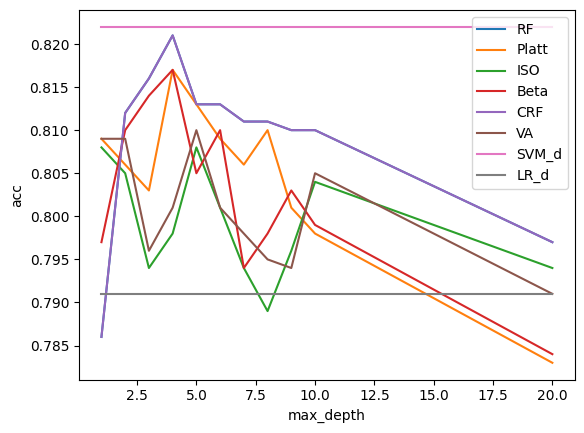

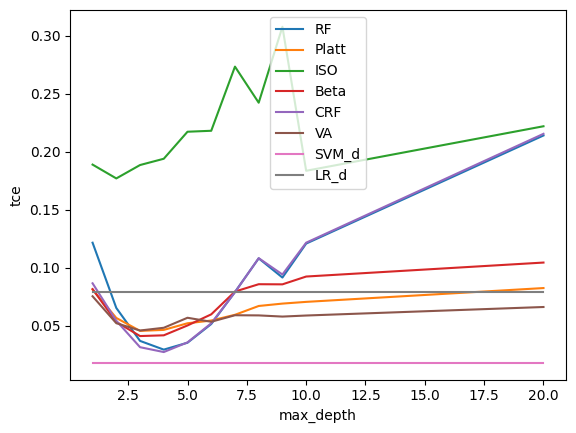

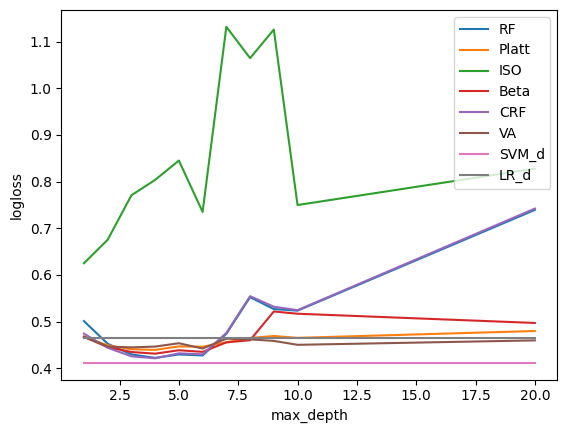

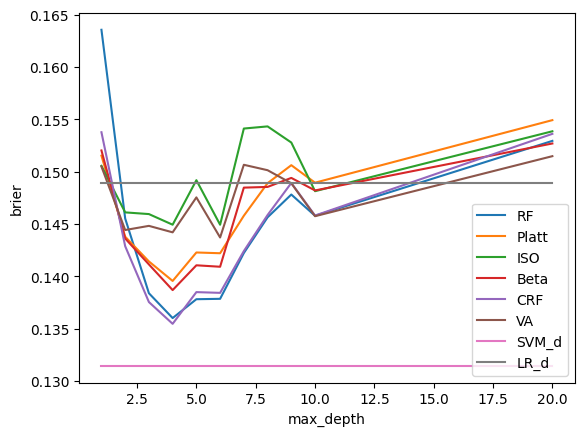

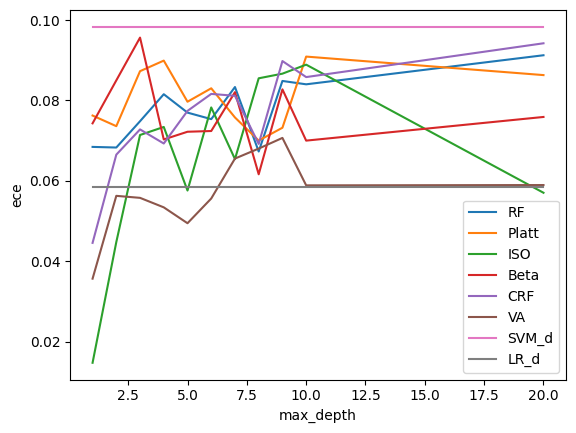

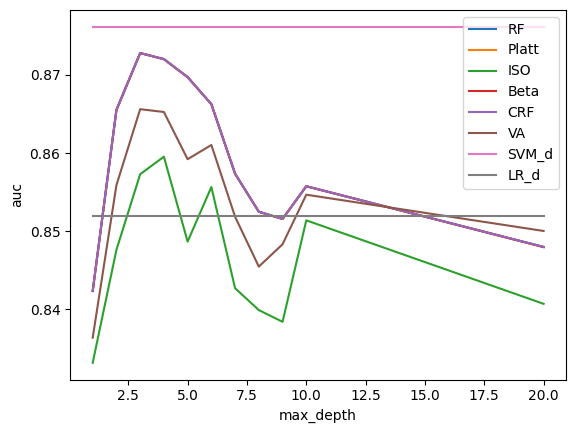

In [13]:
for metric in params["metrics"]:
    ax = tables[metric][plot_calib_methods].plot()
    ax.set_xlabel(params["exp_key"])
    ax.set_ylabel(metric)